In [1]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import ast

/home/max/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


## Pull the document metadata from the xml files from the Pubmed API

In [2]:
document_index = None

for fpath in os.listdir('../data/'):
    if "cohen_all" in fpath:
        ndf = rr.parse_pmxml(f'../data/{fpath}')
    if document_index is None:
        document_index = ndf
    else:
        document_index = pd.concat([document_index,ndf])
        
document_index["text"] = document_index["ab"] + document_index["mesh"]
document_index = document_index.drop_duplicates()
print(document_index.shape)
document_index.head()

(17238, 5)


,ab,PMID,ti,mesh,text
0,"This randomized, double-blind, placebo-control...",9793700,Effect of subcutaneous naratriptan on forearm ...,MESHHEADD000328 MESHHEADD001794 MESHHEADD0185...,"This randomized, double-blind, placebo-control..."
1,A multicenter test was conducted to investigat...,9793701,Effect of operationalized computer diagnosis o...,MESHHEADD000293 MESHHEADD000328 MESHHEADD0004...,A multicenter test was conducted to investigat...
2,Subcutaneous injection of sumatriptan is an ef...,9793702,Sumatriptan nasal spray (20 mg/dose) in the ac...,MESHHEADD000280 MESHHEADD000328 MESHHEADD0003...,Subcutaneous injection of sumatriptan is an ef...
3,The efficacy and adverse effects of 0.25% apra...,9793771,The effect of 0.25% apraclonidine in preventin...,MESHHEADD000316 MESHHEADD000319 MESHHEADD0003...,The efficacy and adverse effects of 0.25% apra...
4,To determine if an intravenous (i.v.) fluid bo...,9793807,An intravenous fluid bolus is not necessary be...,MESHHEADD000328 MESHHEADD015360 MESHHEADD0163...,To determine if an intravenous (i.v.) fluid bo...


In [3]:
document_index.iloc[1, 4]

'A multicenter test was conducted to investigate the effectiveness of the selective serotonin agonist sumatriptan in patients with the computerized headache diagnosis of migraine. A computer program was used for diagnostic evaluation of patients attending a general practice because of headache. The results of the analysis were taken as a direct decision on therapy. If the patients satisfied the criteria for migraine, they were given subcutaneous sumatriptan for treating three migraine attacks. The patients were able to use the study medication under outpatient conditions. The therapeutic efficacy of the medicine was recorded in a headache diary. A total of 91 patients were included in the study at 22 practices in Germany. An average of four patients per practice were recruited. In the first migraine attack treated, headache improvement was experienced by 77.7% of the patients treated. In the second and third attacks an improvement was experienced by 93.5% and 89.8%, respectively. The r

## Load the cohen database of SRs
https://dmice.ohsu.edu/cohenaa/systematic-drug-class-review-data.html

In [4]:
cohen_db = pd.read_csv(
    '../data/epc-ir.clean.tsv',
    sep='\t',header=None,
    #names=["review","EID","PMID","relevant","fulltext_relevant"]
    names=["review","EID","PMID","relevant_ab","relevant"]
)

cohen_db['relevant'] = np.where(cohen_db['relevant']=="I",1,0)
cohen_db = cohen_db[["review","PMID","relevant"]]

cohen_db.head()



,review,PMID,relevant
0,ACEInhibitors,10024335,0
1,ACEInhibitors,10027665,0
2,ACEInhibitors,10027935,0
3,ACEInhibitors,10028936,0
4,ACEInhibitors,10029645,0


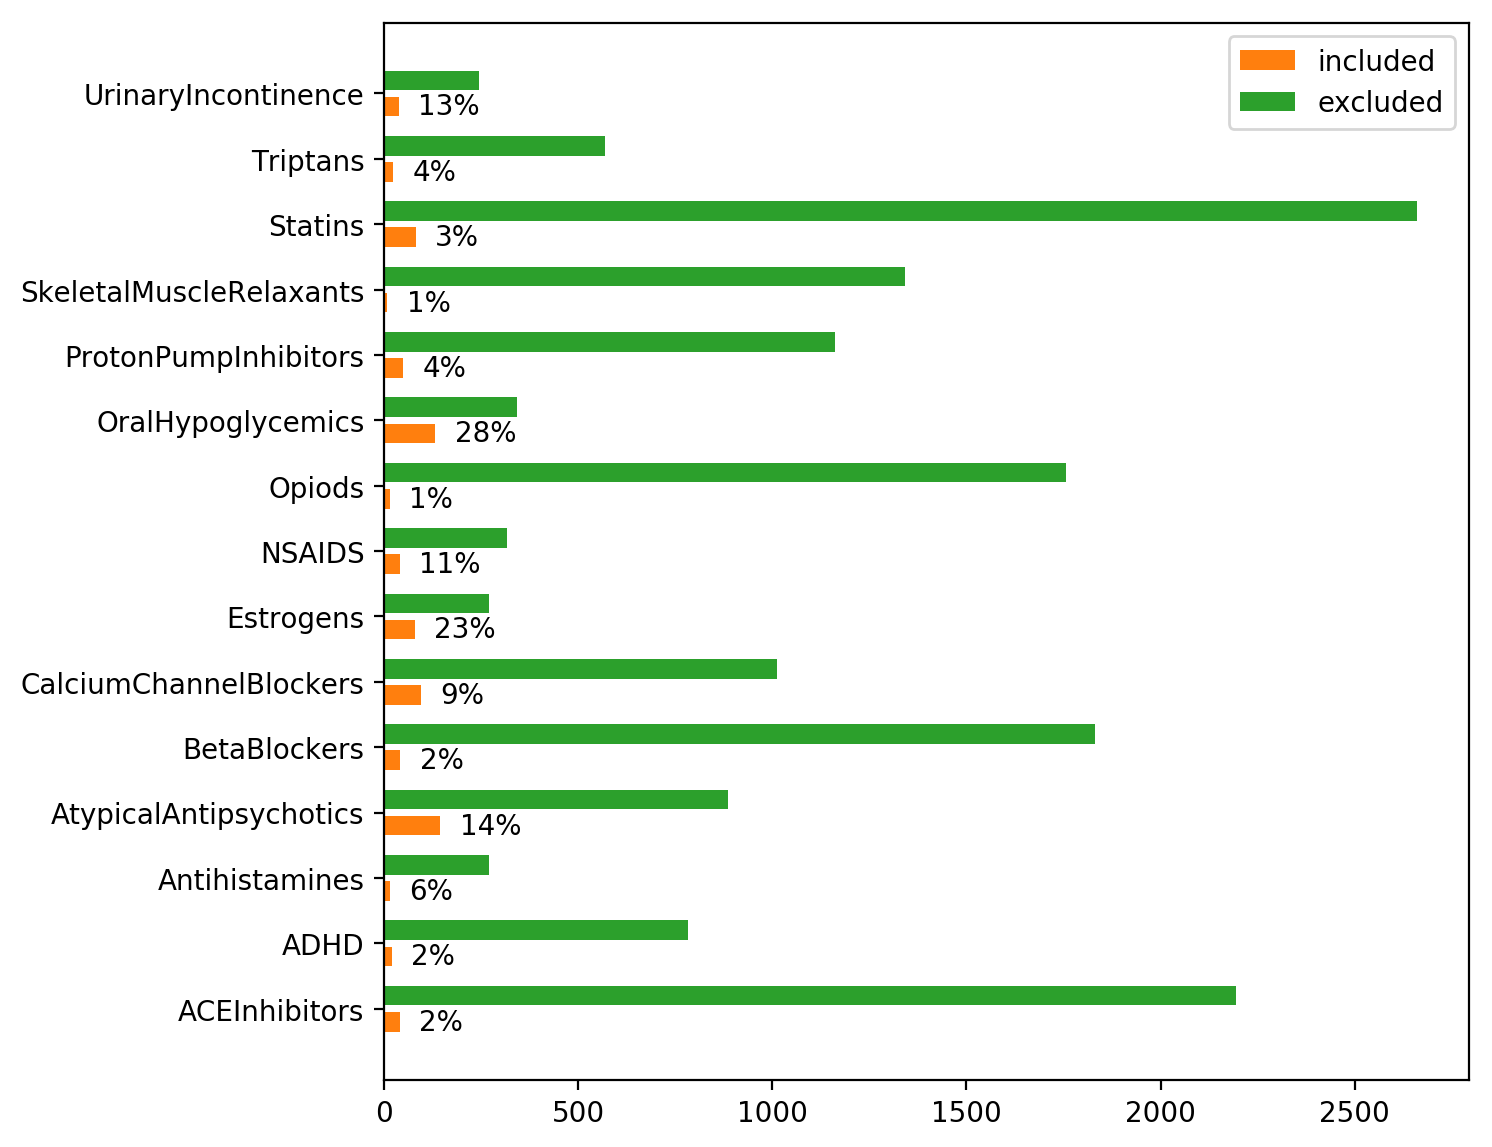

In [5]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(cohen_db.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = pd.merge(
        group,
        document_index,
    )
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/(included+excluded):.0%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [6]:
importlib.reload(rr)

recalculate = False
if recalculate:
    models = [
        SVC(kernel='linear',class_weight='balanced',probability=True)
        #MultinomialNB(alpha=0.1)    
        #MLPClassifier(
        #    solver='lbfgs', 
        #    alpha=0.1,
        #    hidden_layer_sizes=(10), 
        #    random_state=1
        #)
    ]
    iterations = 1

    results = []
    rs_results = []
    paths = []
    for name, group in cohen_db.groupby('review'):
        df = pd.merge(
            group,
            document_index,
        )
        df['x'] = df['mesh']
        df = df[df['x']!=" "]
        df = df.dropna().reset_index(drop=True)
        #if df.shape[0] > 1000:
            #continue
        if name not in ["Opiods"]:#,"BetaBlockers"]:
            continue
        ss = rr.ScreenScenario(
            df, models, 500, [50,100,200], name
        )
        for i in range(iterations):
            results.append(ss.screen(i, True))
            #print(ss.recall_rs)
        break

    results_df = pd.DataFrame.from_dict(results)

    
else:
    dfs = []
    for suffix, label in [("","cohen"), ("_pb_copd","copd_pb"), ("_fr", "fastread")]:
        df = pd.read_csv(f'../results/results{suffix}.csv')
        df['data_source'] = label
        df = df[df['iteration']<=9]
        print(df['iteration'].max())
        dfs.append(df)
    results_df = pd.concat(dfs)
    print(results_df.shape)
    for p in ["estimated_recall_path", "recall_track", "work_track","random_work_track","random_recall_track"]:
        results_df[p] = results_df[p].apply(ast.literal_eval)
    
#rs_results_df.head()    


9
9
9
(310, 66)


/home/max/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



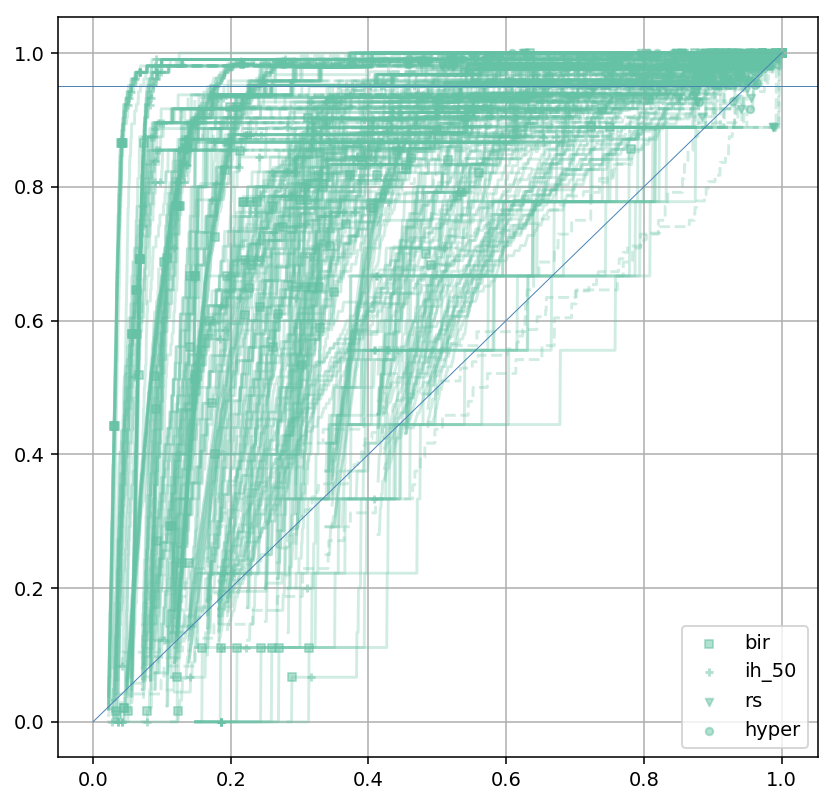

In [22]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.3
size = 15

pdf = results_df[results_df[''] > 1000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--")
    #ax.plot(p['random_work_track'], p['estimated_recall_path'])
    #ax.plot(p['random_work_track'], p['estimated_p_path'])
    
s_crit = ["bir","ih_50","rs", "hyper"]

import itertools
marker = itertools.cycle((',', '+', 'v', 'o', '*',':')) 

#ax.scatter(pdf['random_start_work'],pdf['random_start_recall'],c=colors[0],s=size,alpha=a+0.2)

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss95_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s,
        s = size,
        alpha=a+0.2
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()

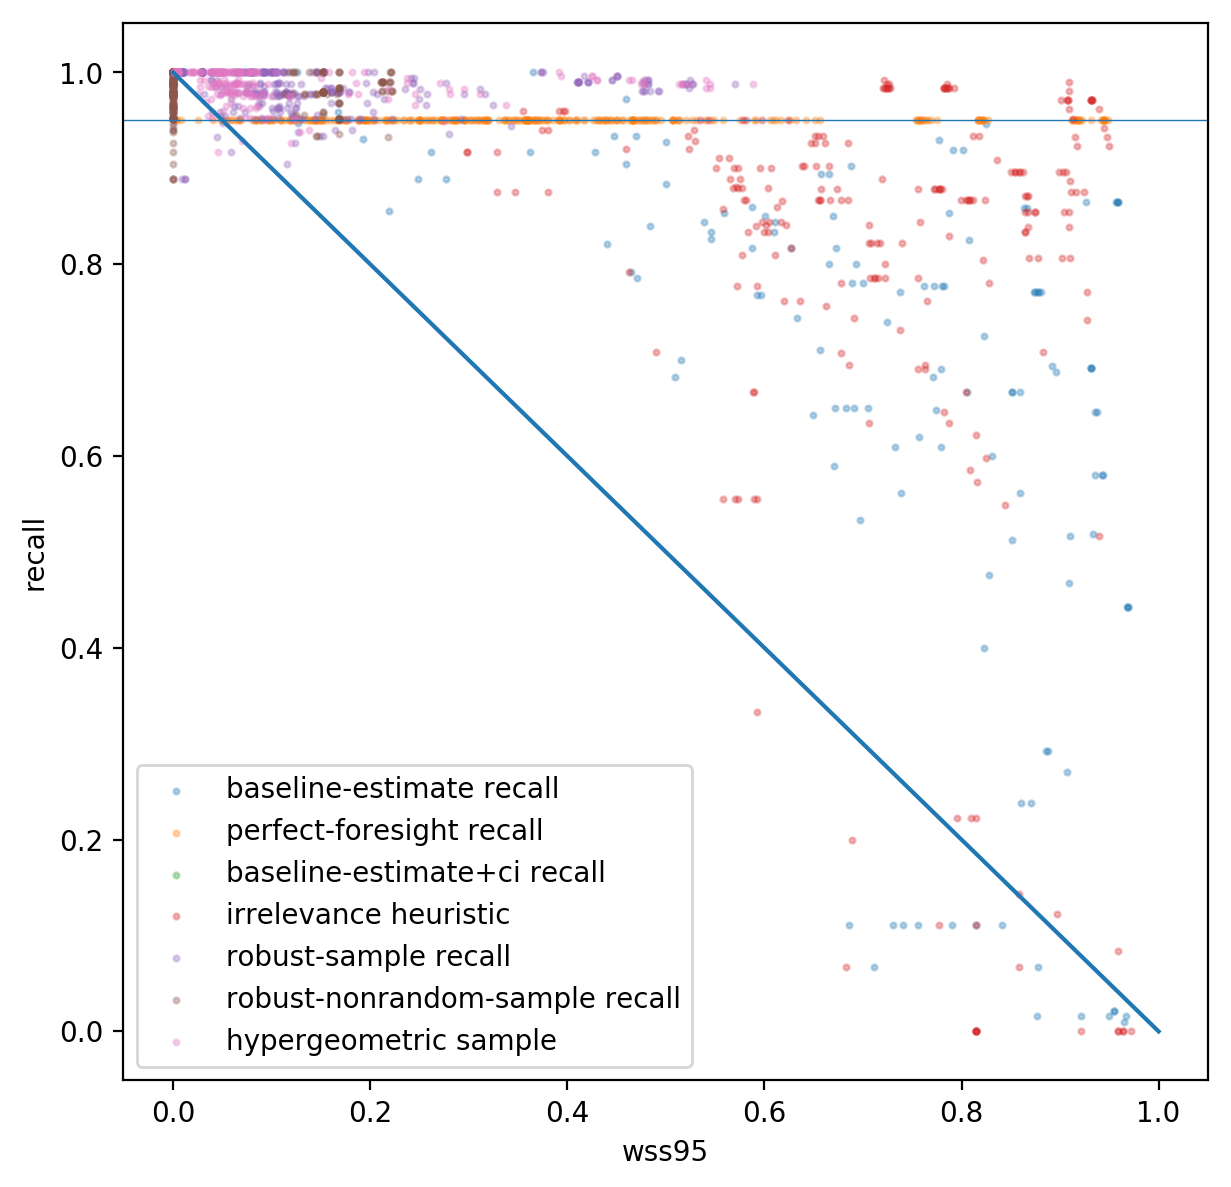

In [10]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
s = 4
a = 0.3
ax.scatter(
    results_df['wss95_bir'], results_df['recall_bir'], 
    alpha=a, 
    label="baseline-estimate recall",
    s=s
)
ax.scatter(
    results_df['wss95_pf'], 
    [0.95 for x in results_df['recall_pf']], 
    alpha=a,
    label="perfect-foresight recall",
    s=s
)

ax.scatter(
    results_df['wss95_bir_ci'], 
    results_df['recall_bir_ci'], 
    alpha=a,
    label="baseline-estimate+ci recall",
    s=s
)

ax.scatter(
    results_df['wss95_ih_50'], 
    results_df['recall_ih_50'], 
    alpha=a,
    label="irrelevance heuristic",
    s=s
)

ax.scatter(
    results_df['wss95_rs'], results_df['recall_rs'], 
    alpha=a, 
    label="robust-sample recall",
    s=s
)

ax.scatter(
    results_df['wss95_nrs'], results_df['recall_rs'], 
    alpha=a, 
    label="robust-nonrandom-sample recall",
    s=s
)

ax.scatter(
    results_df['wss95_hyper'], results_df['recall_hyper'], 
    alpha=a, 
    label="hypergeometric sample",
    s=s
)

ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.plot([1,0],)

ax.axhline(0.95, lw=0.5)
plt.show()

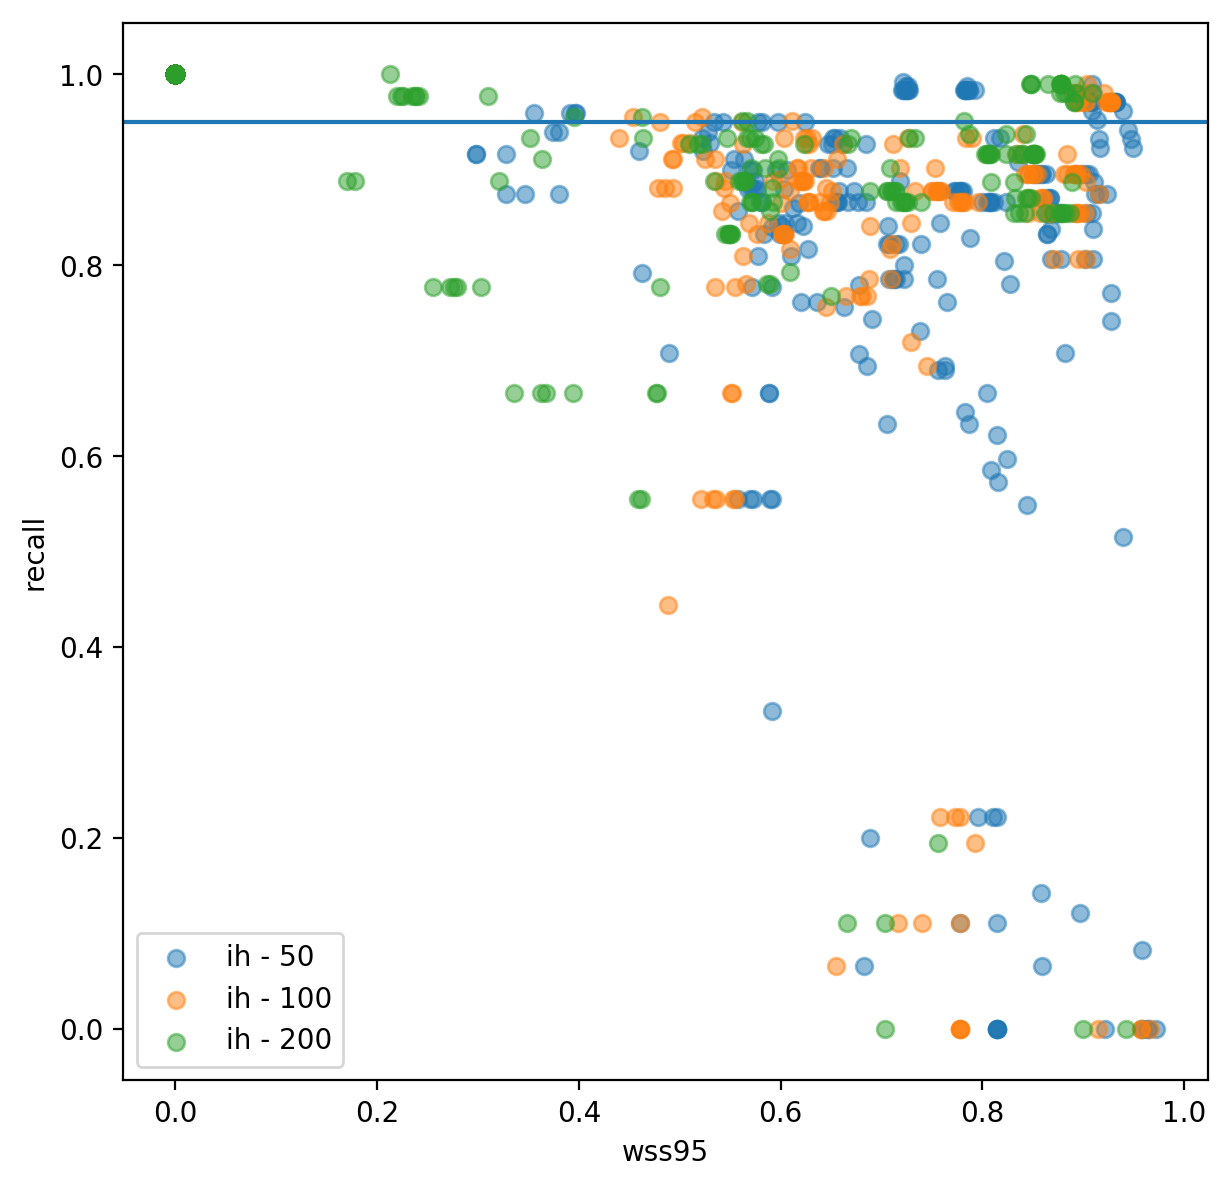

In [11]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
for ih in [50,100,200]:
    ax.scatter(
        results_df[f'wss95_ih_{ih}'], results_df[f'recall_ih_{ih}'], 
        alpha=0.5, 
        label=f"ih - {ih}"
    )


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.axhline(0.95)
plt.show()

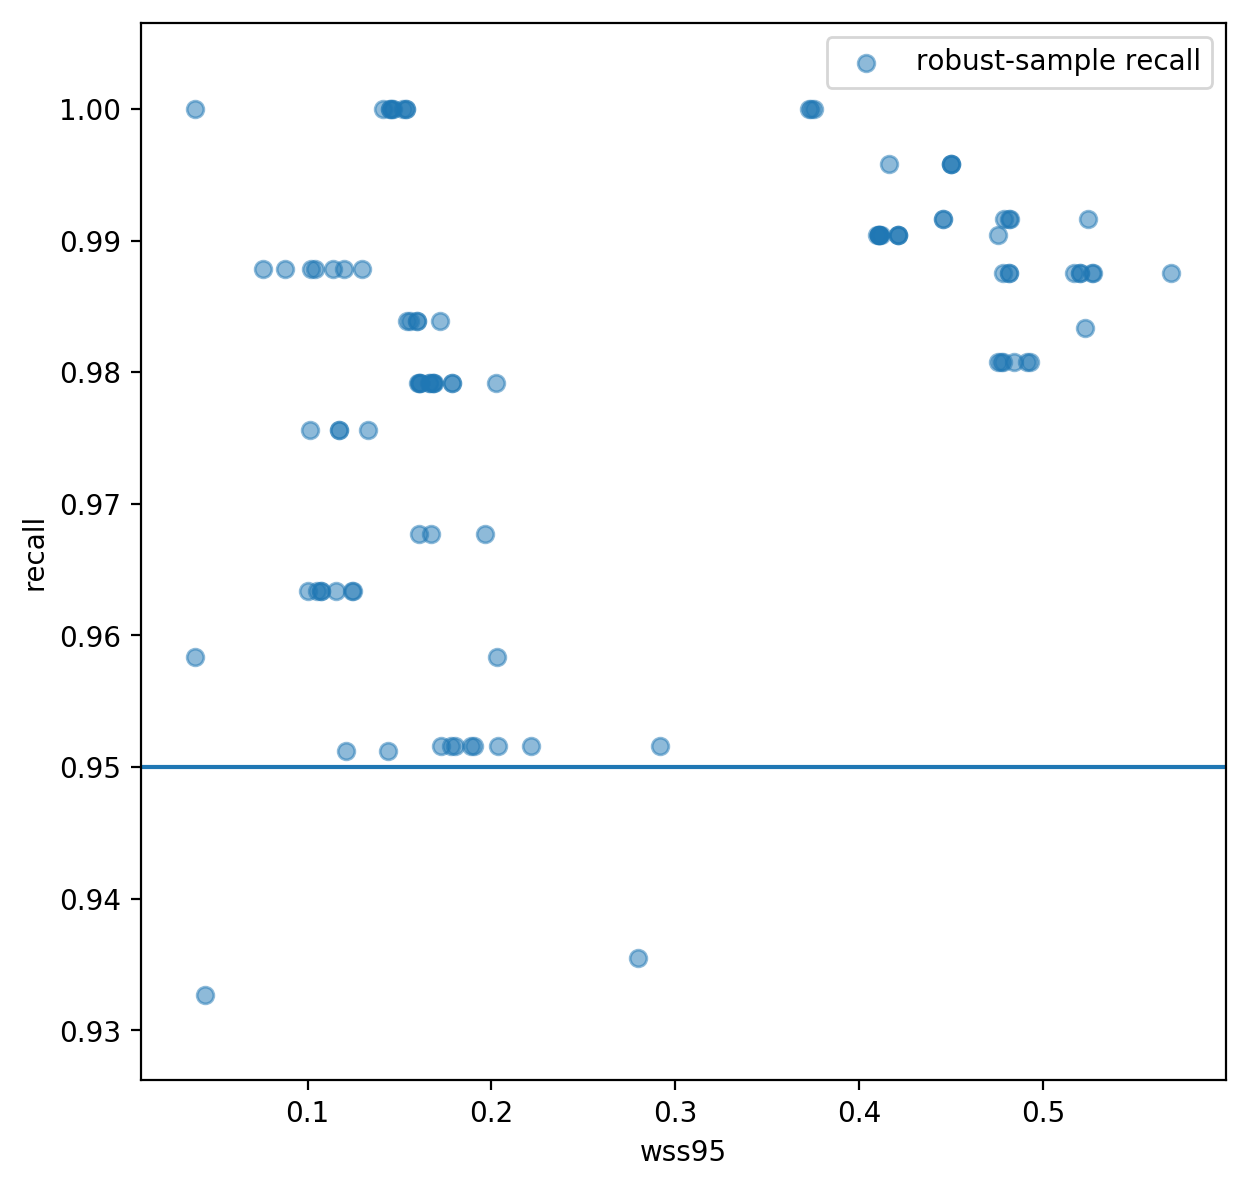

In [12]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

pdf = results_df.query('N > 2500')

ax.scatter(
    pdf['wss95_rs'], pdf['recall_rs'], 
    alpha=0.5, 
    label="robust-sample recall"
)


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.axhline(0.95)
plt.show()

120
6


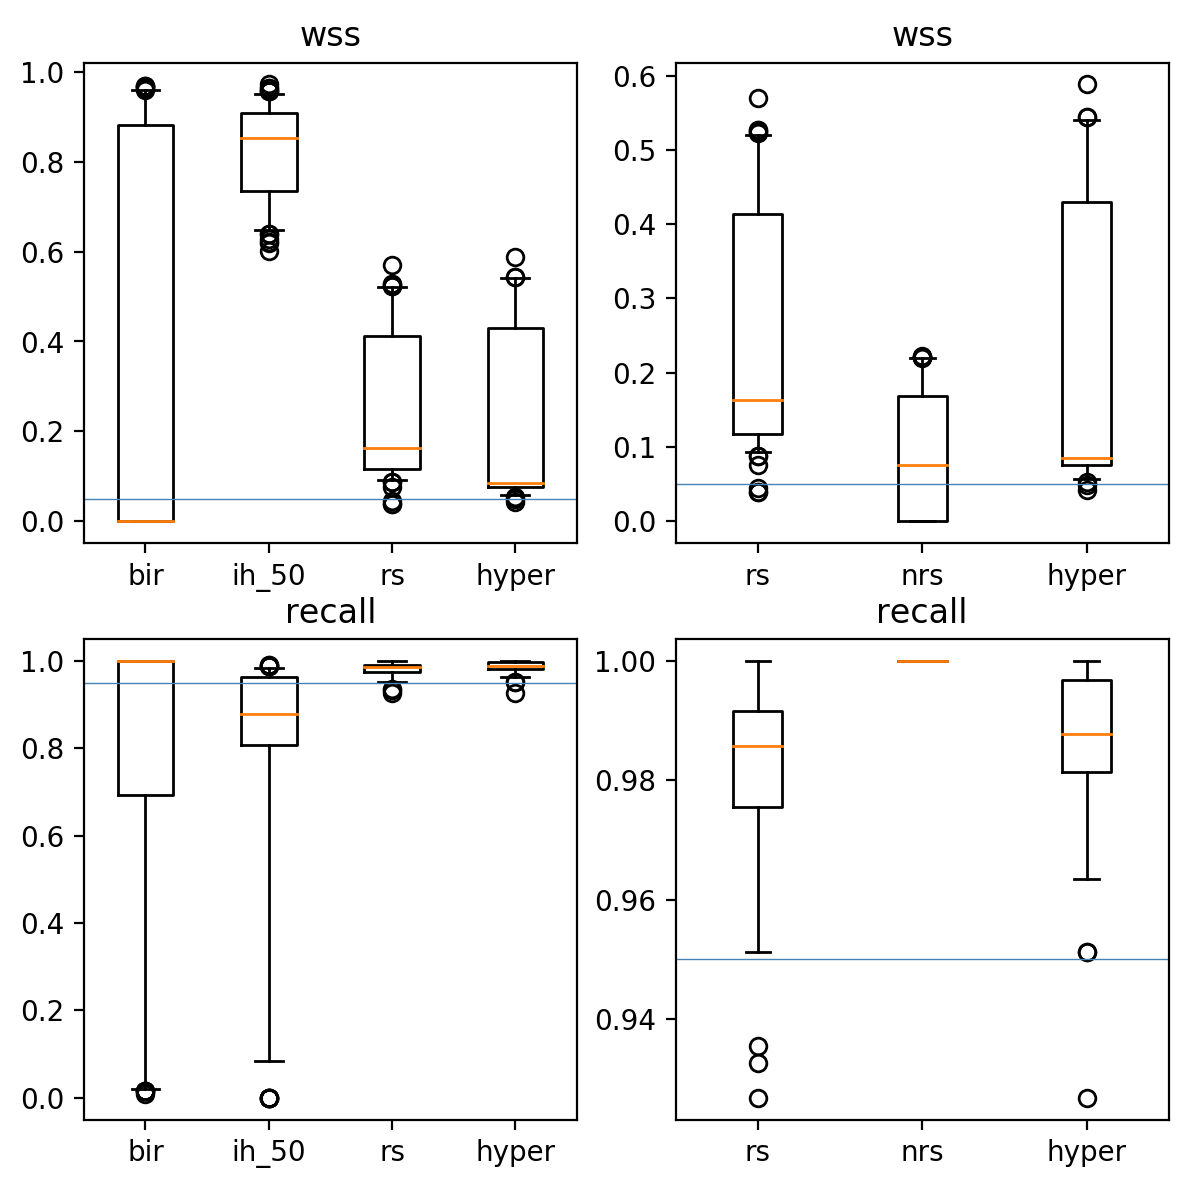

In [40]:
fig, axs = plt.subplots(2,2, figsize=(7,7),dpi=200)

rs_crit = ['rs','nrs','hyper']

pdf = results_df[(results_df['N'] > 2000) & (pd.notnull(results_df['recall_pf']))]

print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss95',0.05), (1,'recall',0.95)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[5,95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="steelblue",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

plt.show()

40
2


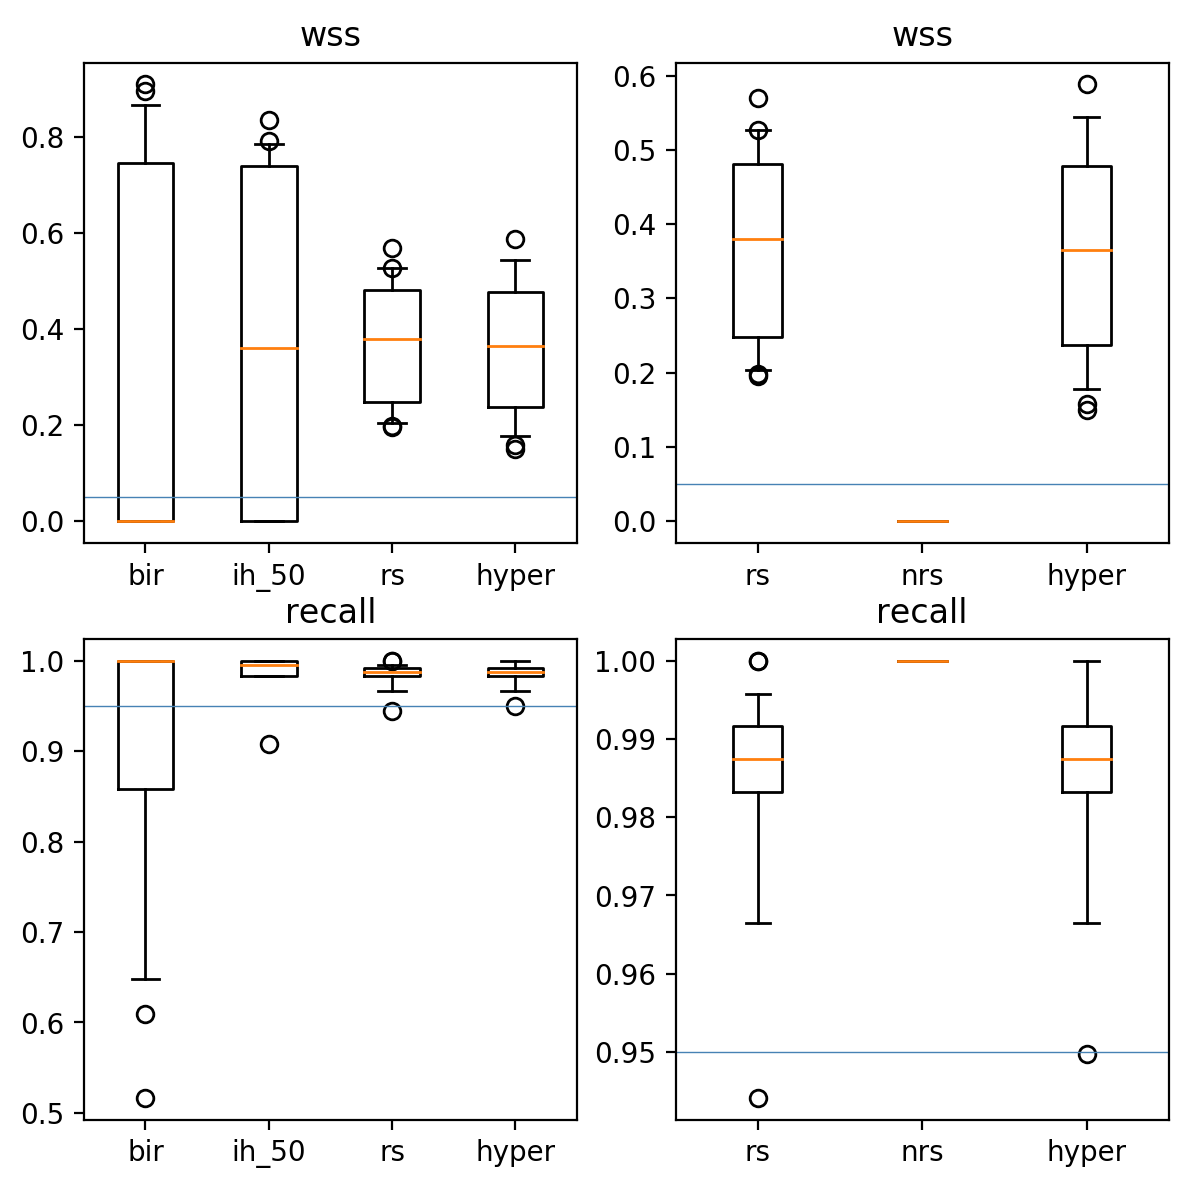

In [54]:
fig, axs = plt.subplots(2,2, figsize=(7,7),dpi=200)

rs_crit = ['rs','nrs','hyper']

pdf = results_df[(results_df['data_source'] == "copd_pb") & (pd.notnull(results_df['recall_pf']))]

print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss95',0.05), (1,'recall',0.95)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[5,95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="steelblue",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

plt.show()

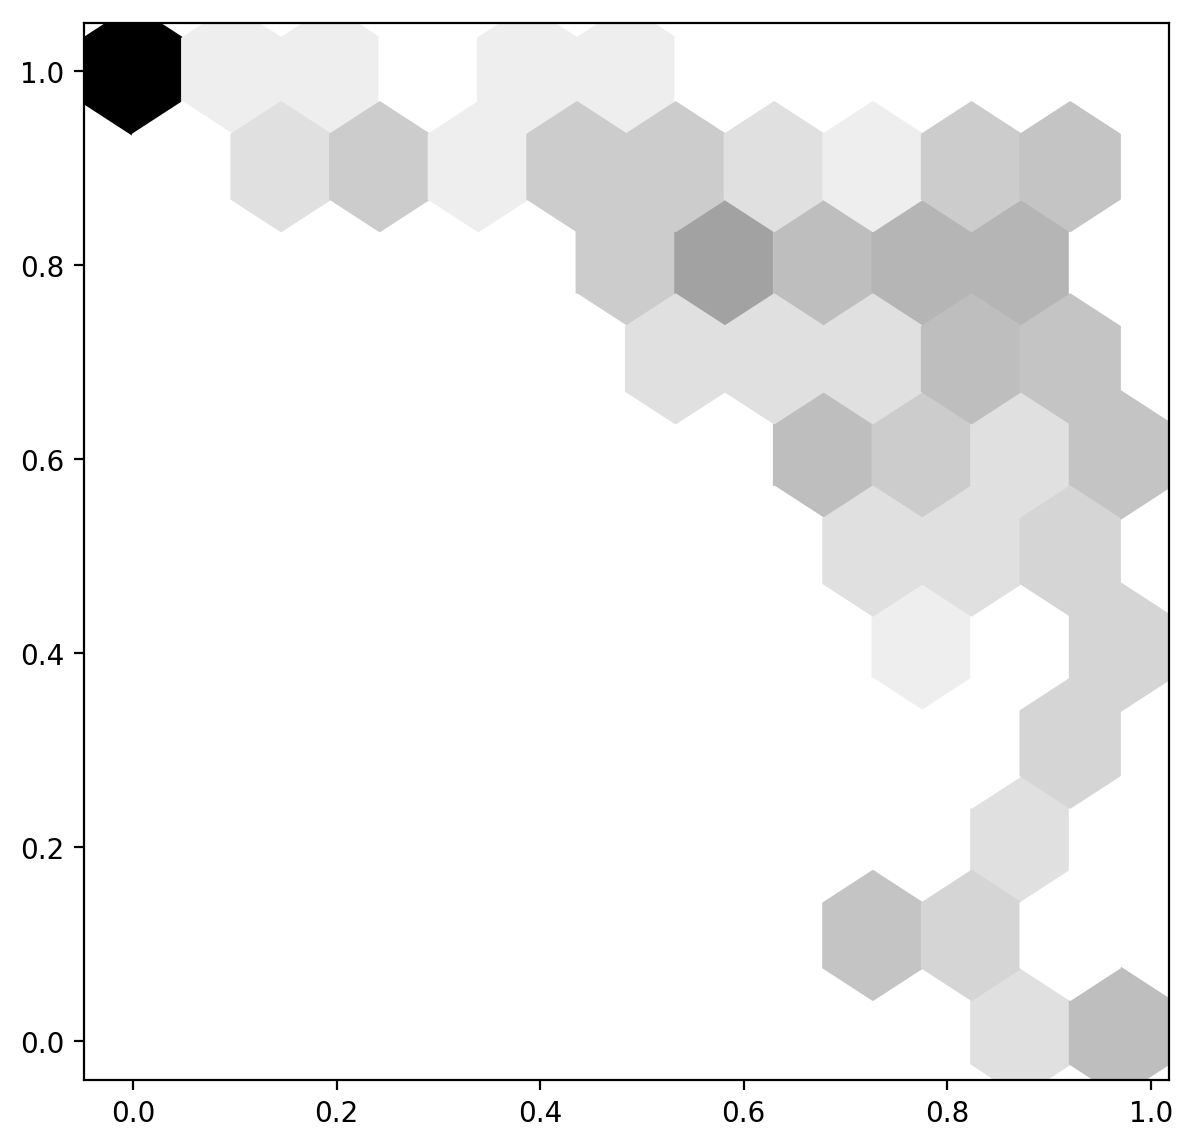

In [24]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_bir'], 
    results_df['recall_bir'], 
    gridsize=10, 
    mincnt=0,
    bins="log",
    cmap = "Greys"
)
plt.show()

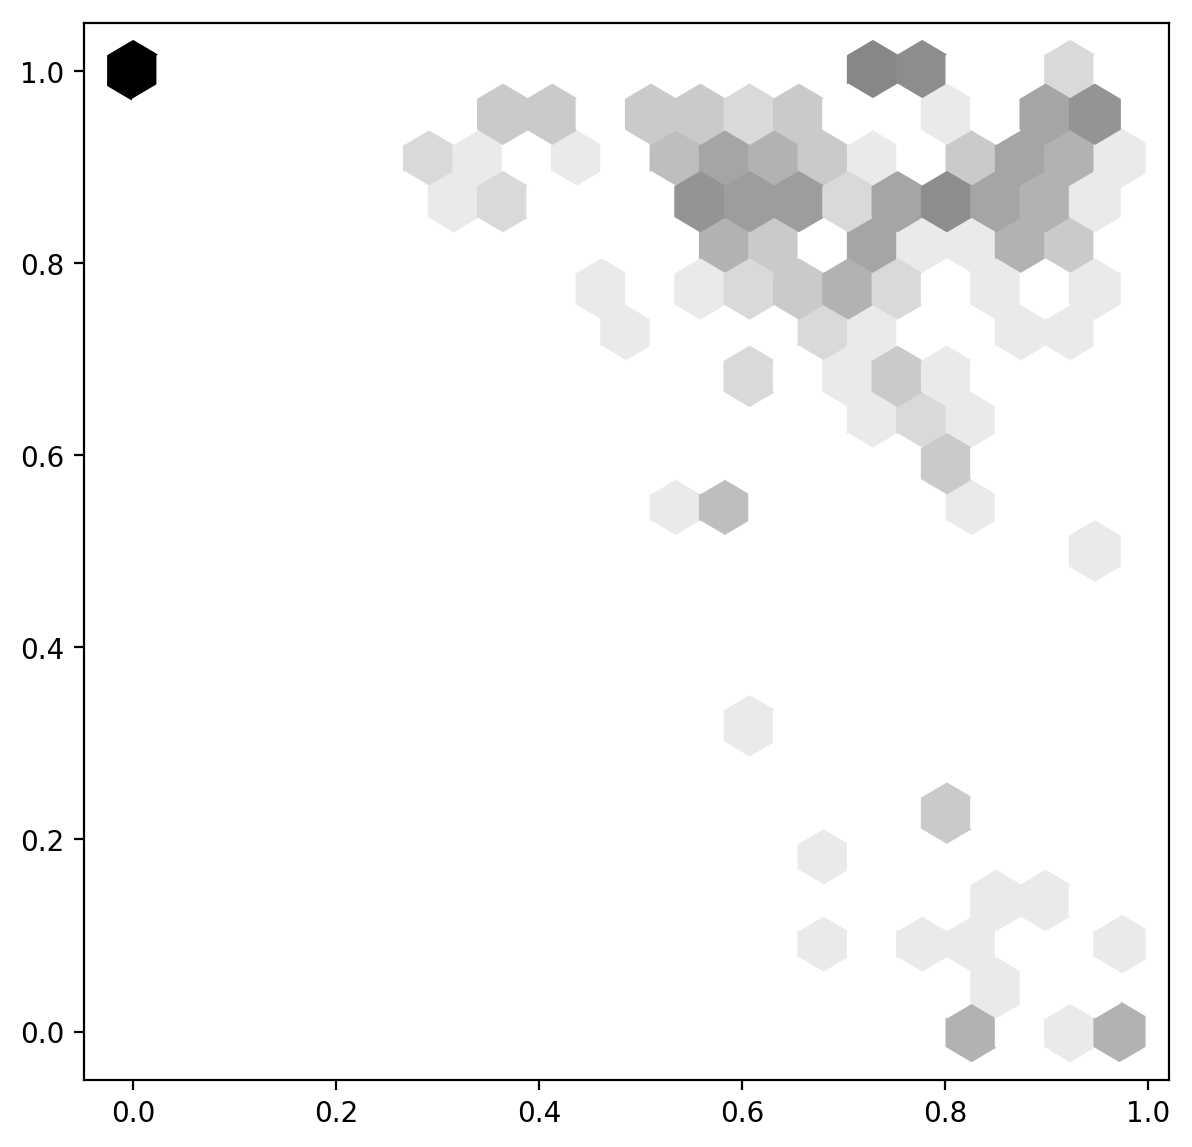

In [25]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_ih_50'], 
    results_df['recall_ih_50'], 
    gridsize=20, 
    mincnt=0,
    cmap="Greys",
    bins="log"
)
plt.show()

Index(['N', 'X_sample', 'X_sample_path', 'bir', 'bir_upperbound',
       'data_source', 'dataset', 'estimated_missed', 'estimated_p_path',
       'estimated_p_ub', 'estimated_r_docs', 'estimated_recall_min',
       'estimated_recall_path', 'hyper_hypo_path', 'hyper_interval',
       'hyper_linterval_path', 'hyper_prob', 'hyper_prob_pmf',
       'hyper_uinterval_path', 'hypothetical_95', 'irrelevant_heuristic',
       'iteration', 'iteration_size', 'iterations', 'last_iteration_relevance',
       'max_prob_recall', 'models', 'n_remaining', 'n_remaining_pre_sample',
       'n_sample', 'p', 'r_docs', 'r_predicted', 'r_predicted_upperbound',
       'r_seen', 'r_seen_pre_sample', 'random_recall_track',
       'random_start_recall', 'random_start_work', 'random_work_track',
       'ratings', 'recall', 'recall_bir', 'recall_bir_ci', 'recall_hyper',
       'recall_ih_100', 'recall_ih_200', 'recall_ih_50', 'recall_nrs',
       'recall_pf', 'recall_rs', 'recall_track', 'results', 's', 'seen_docs

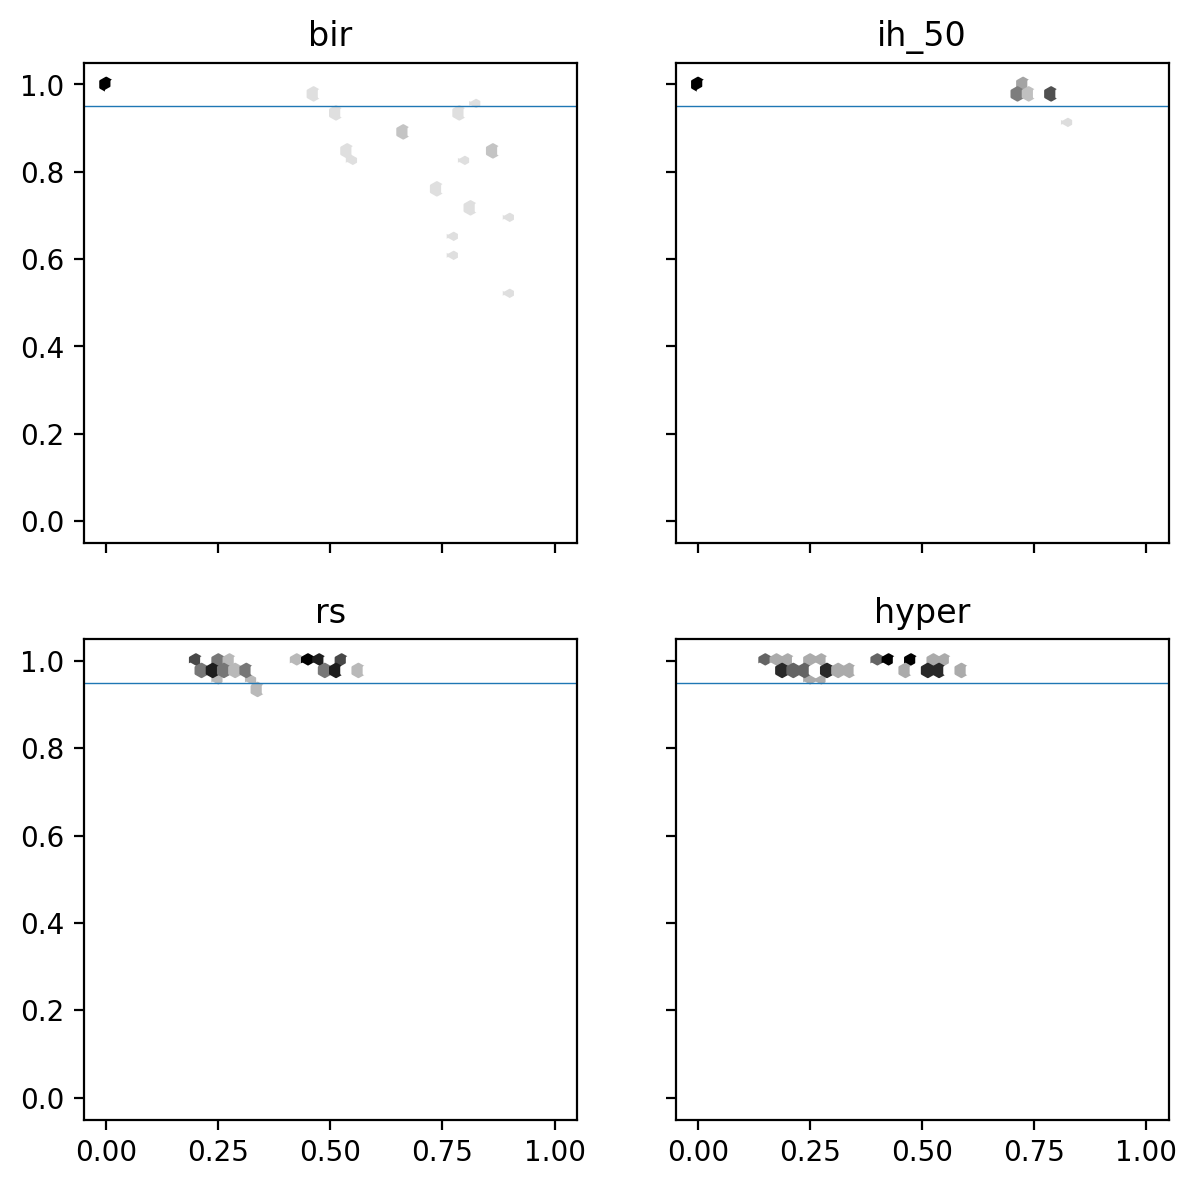

In [48]:
fig, axs = plt.subplots(2,2,figsize=(7,7),dpi=200,sharey=True, sharex=True)

cols = [f'wss95_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()

for i, ss in enumerate(s_crit):
    ax = axs[i//2][i%2]
    ax.hexbin(
        pdf[f'wss95_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)
plt.show()    

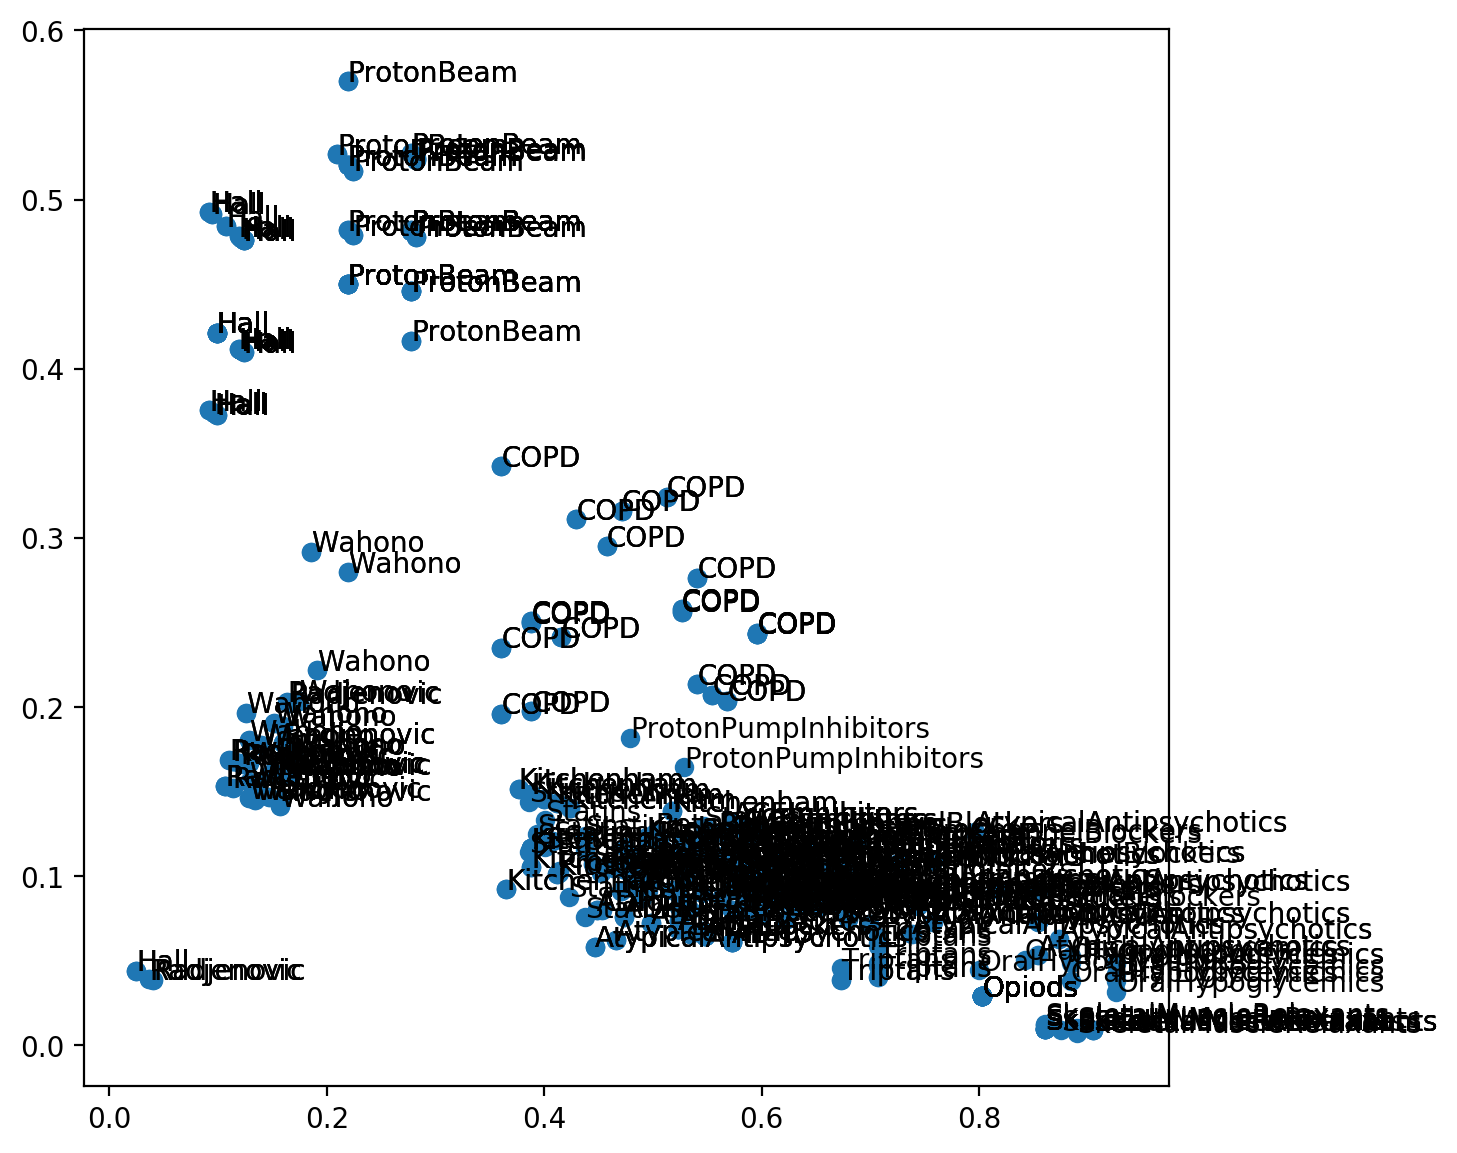

In [44]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

df = results_df
df = df.loc[df[['random_start_work','wss95_rs']].dropna().index,:]

x = 'random_start_work'

ax.scatter(
    df[x], 
    df['wss95_rs'], 
)
for i, row in df.iterrows():
    ax.text(
        row[x], 
        row['wss95_rs'], 
        row['dataset']
    )
plt.show()

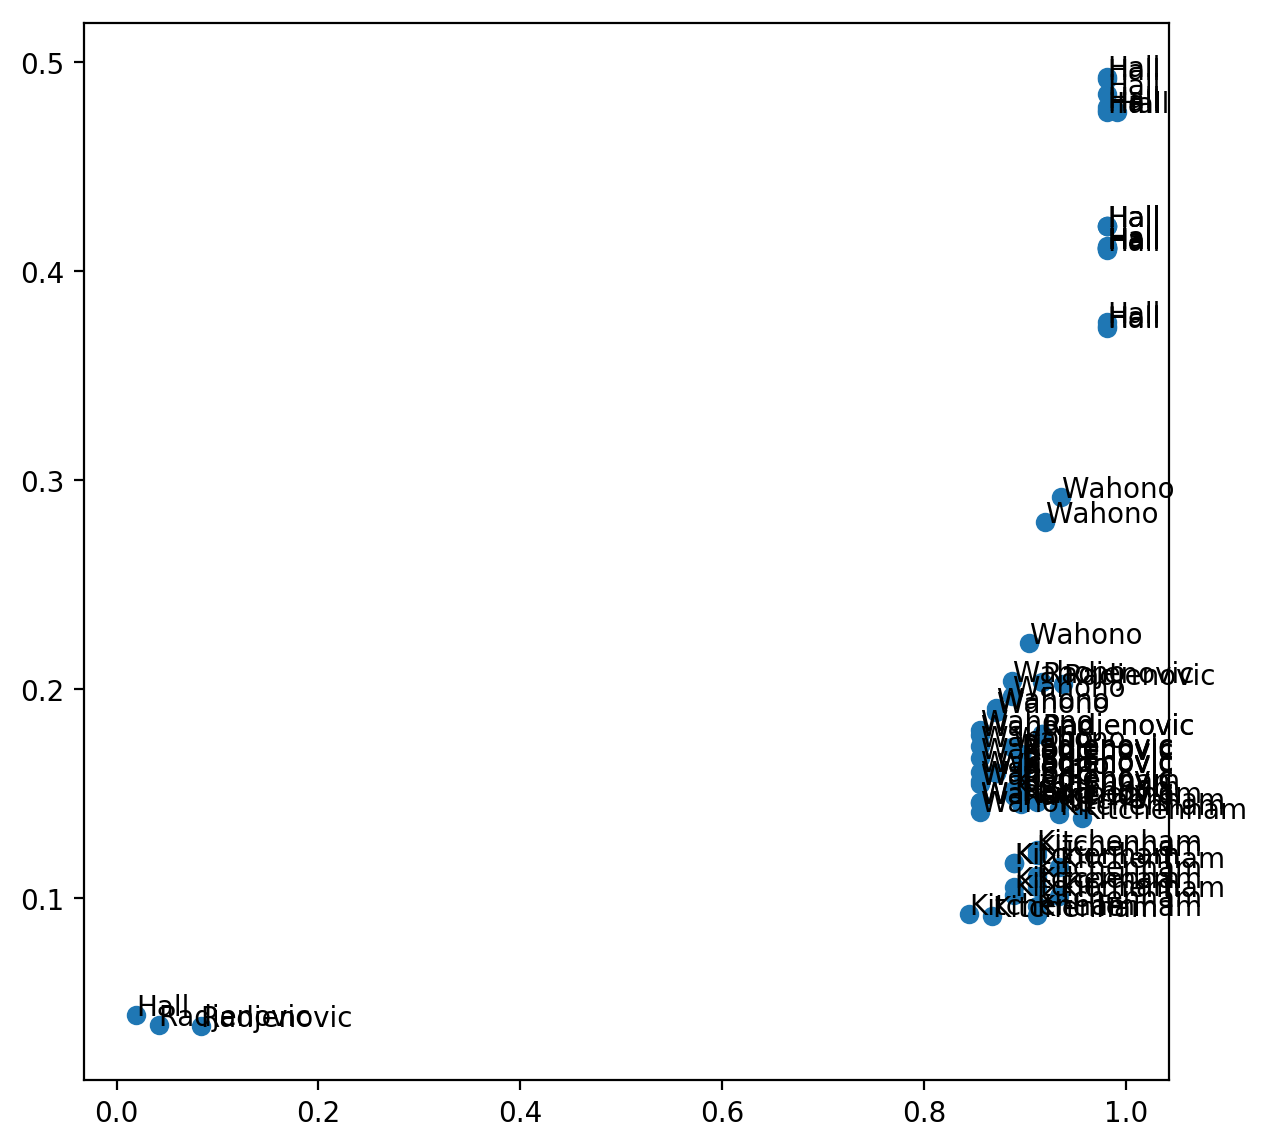

In [42]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

x = 'random_start_recall'

ax.scatter(
    df[x], 
    df['wss95_rs'], 
)
for i, row in df.iterrows():
    ax.text(
        row[x], 
        row['wss95_rs'], 
        row['dataset']
    )
plt.show()

[Text(0, 0, 'ACEInhibitors'),
 Text(0, 0, 'ADHD'),
 Text(0, 0, 'AtypicalAntipsychotics'),
 Text(0, 0, 'BetaBlockers'),
 Text(0, 0, 'CalciumChannelBlockers'),
 Text(0, 0, 'Opiods'),
 Text(0, 0, 'OralHypoglycemics'),
 Text(0, 0, 'ProtonPumpInhibitors'),
 Text(0, 0, 'SkeletalMuscleRelaxants'),
 Text(0, 0, 'Statins'),
 Text(0, 0, 'Triptans'),
 Text(0, 0, 'COPD'),
 Text(0, 0, 'ProtonBeam'),
 Text(0, 0, 'Hall'),
 Text(0, 0, 'Kitchenham'),
 Text(0, 0, 'Radjenovic'),
 Text(0, 0, 'Wahono')]

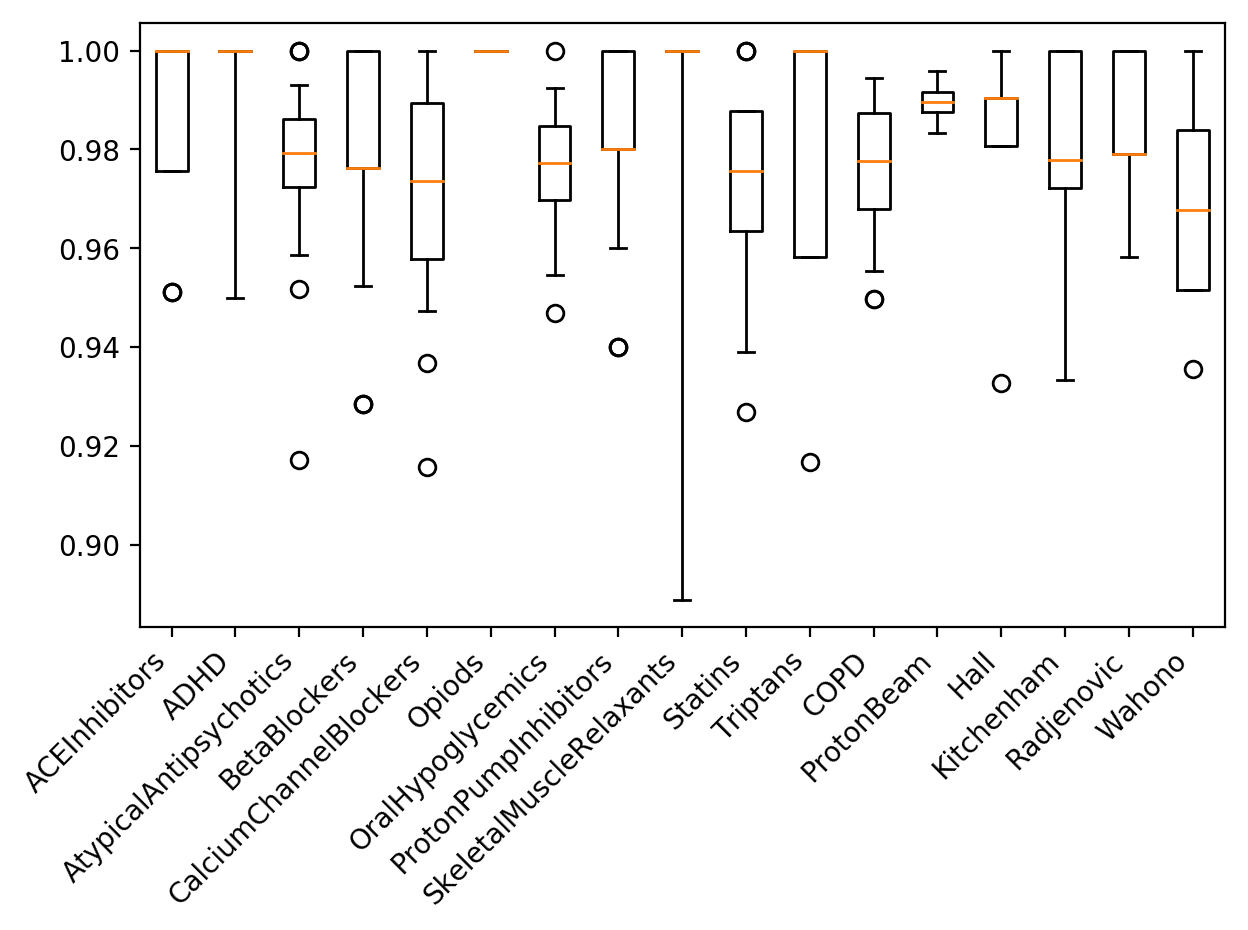

In [32]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

datasets = results_df['dataset'].unique()

ax.boxplot([results_df[results_df['dataset']==d]['recall_rs'].dropna() for d in datasets], whis=[5,95])

ax.set_xticklabels(datasets, rotation=45,ha="right")

[Text(0, 0, 'ACEInhibitors'),
 Text(0, 0, 'ADHD'),
 Text(0, 0, 'AtypicalAntipsychotics'),
 Text(0, 0, 'BetaBlockers'),
 Text(0, 0, 'CalciumChannelBlockers'),
 Text(0, 0, 'Opiods'),
 Text(0, 0, 'OralHypoglycemics'),
 Text(0, 0, 'ProtonPumpInhibitors'),
 Text(0, 0, 'SkeletalMuscleRelaxants'),
 Text(0, 0, 'Statins'),
 Text(0, 0, 'Triptans'),
 Text(0, 0, 'COPD'),
 Text(0, 0, 'ProtonBeam'),
 Text(0, 0, 'Hall'),
 Text(0, 0, 'Kitchenham'),
 Text(0, 0, 'Radjenovic'),
 Text(0, 0, 'Wahono')]

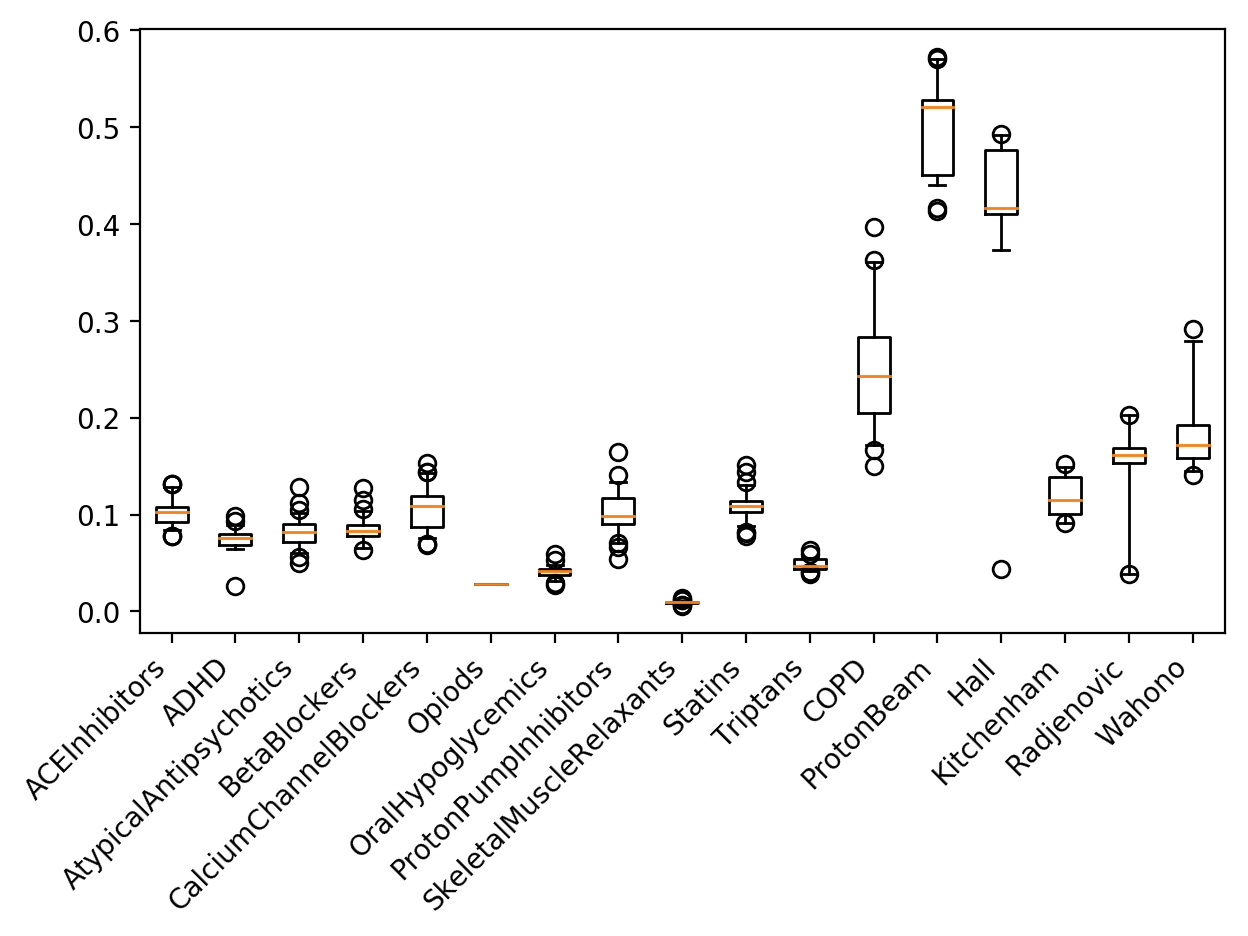

In [33]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

datasets = results_df['dataset'].unique()

ax.boxplot([results_df[results_df['dataset']==d]['wss95_rs'].dropna() for d in datasets], whis=[5,95])

ax.set_xticklabels(datasets, rotation=45,ha="right")